In [199]:
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3dexp.db

from utils import get_by_expnames, get_by_ext, pretty

In [213]:
# dataset = 'jpeg/flickr50k'
num_workers=8
hostname='cloudlet027'

df_all = pd.read_sql(
    'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
        WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
    s3dexp.db.engine,
    params=["macro-%", hostname, num_workers])

df_all

,expname,basedir,avg_wall_ms,throughput,num_workers,bandwidth,avg_cpu_ms
0,macro-obama-hdd,/mnt/hdd/fast20/jpeg/flickr50k,68.350879,14.630390,8,1.102007,542.236143
1,macro-obama-smart,/mnt/hdd/fast20/jpeg/flickr50k,33.614442,29.749118,8,0.627098,11.188473
2,macro-obama-ssd,/mnt/ssd/fast20/jpeg/flickr50k,68.036684,14.697953,8,1.107096,540.884425
3,macro-pedestrian-hdd,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,3.218230,310.729780,8,10.780236,8.430496
4,macro-pedestrian-smart,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,2.894923,345.432287,8,95.525618,1.778842
5,macro-pedestrian-ssd,/mnt/ssd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,3.194209,313.066548,8,10.861306,8.381142
6,macro-redbus-hdd,/mnt/hdd/fast20/jpeg/flickr50k,4.008679,249.458734,8,18.790009,6.535407
7,macro-redbus-smart,/mnt/hdd/fast20/jpeg/flickr50k,2.007485,498.135849,8,521.898845,3.973540
8,macro-redbus-ssd,/mnt/ssd/fast20/jpeg/flickr50k,2.055716,486.448589,8,36.640822,7.151260


## HDD vs SSD vs Ours

In [214]:
workloads = ['redbus', 'obama', 'pedestrian']

devices = ['hdd', 'ssd', 'smart']
device_names = ['HDD', 'SSD', 'Active Disk']
colors = ['tab:gray', 'tab:blue', 'tab:red']

In [215]:
%matplotlib notebook

def plot_macro(col = 'throughput', ylabel = 'Images / s', savefig_path = 'macro-throughput.pdf', ymax=None):
    plt.figure(figsize=(6,3))

    ind = np.arange(len(workloads))
    width = 0.25       

    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])

        x, y = ind + i*width, df[col]
        plt.bar(x, y, width, label=dev_name, color=c)
        
        # clip y in case y > ymax
        if ymax:
            y = np.minimum(y, ymax)
        
        if col == 'throughput' and dev != 'hdd':
            # annotate speed-up
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['throughput']):
                plt.annotate('{:.1f}x'.format(s1), (x1 - width*.4, y1 + 30))
                
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['avg_cpu_ms']):
                print x1, y1, s1
                plt.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + 1))
            


    plt.ylabel(ylabel)
    plt.ylim(None, ymax)
    plt.xticks(ind + width, map(pretty, workloads))
    plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
    # plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(savefig_path, bbox_inches ='tight')

    plt.show()

<IPython.core.display.Javascript object>


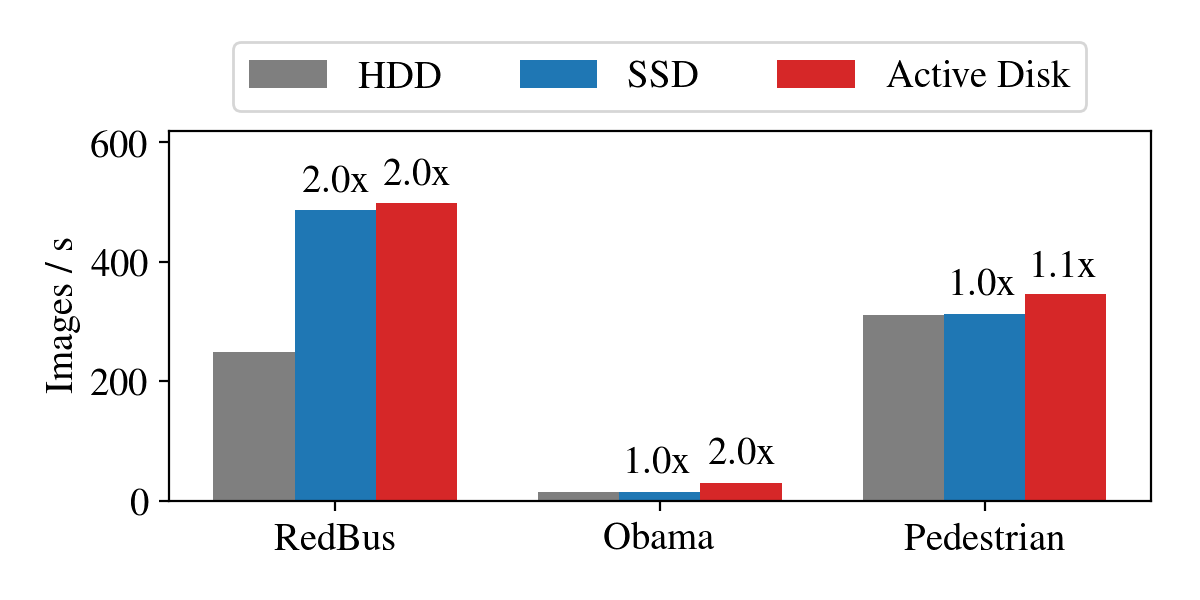

<IPython.core.display.Javascript object>


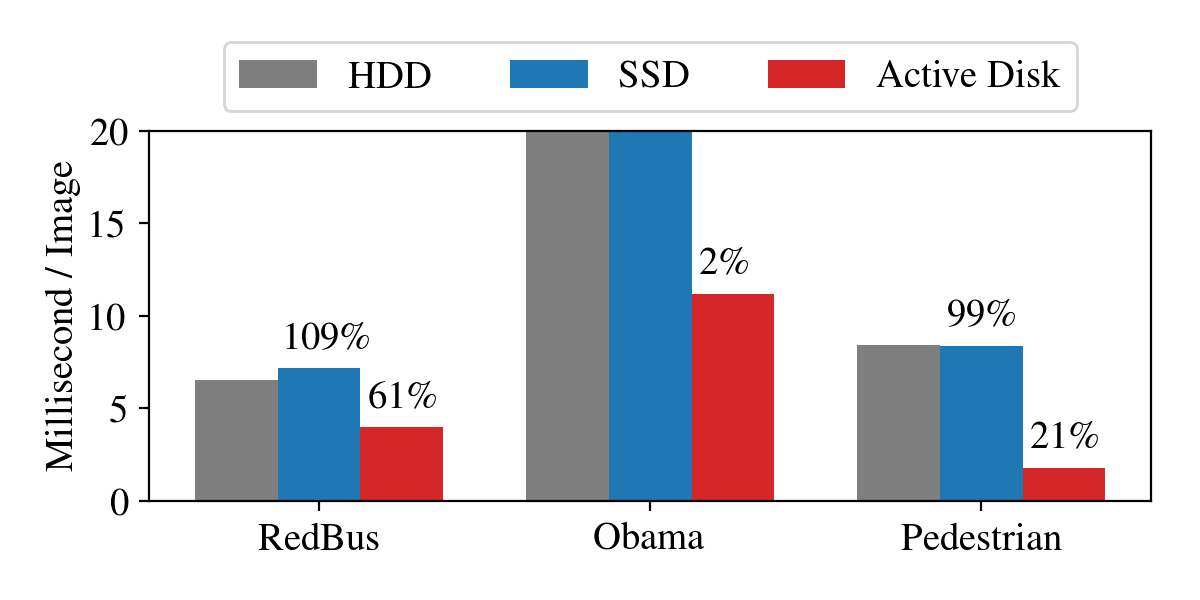

annotating CPU time saving
0.25 7.15126012759 1.09423326483
1.25 20.0 0.036884298981
2.25 8.38114209058 0.994145835348
annotating CPU time saving
0.5 3.97354044125 0.608001953838
1.5 11.188473049 0.0206339492541
2.5 1.77884181155 0.211000858783


In [216]:
plot_macro('throughput', 'Images / s', savefig_path='macro-throughput.pdf', ymax=620)
# plot_macro('bandwidth', 'MByte / s', savefig_path= 'macro-bandwidth.pdf')
plot_macro('avg_cpu_ms', 'Millisecond / Image', savefig_path = 'macro-cputime.pdf', ymax=20)

In [210]:
%matplotlib notebook

def plot_macro_relative(col = 'throughput', ylabel = 'Images / s', savefig_path = 'macro-throughput.pdf', 
                        ymax=None, fn = lambda y0,y: np.divide(y, y0)):
    
    plt.figure(figsize=(6,3))

    ind = np.arange(len(workloads))
    width = 0.25       
    
    df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
    print df_hdd
    
    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])
#         print df

        x, y = ind + i*width, fn(df_hdd[col].values, df[col].values)
        
        print "x=", x, "y=", y
        
        plt.bar(x, y, width, label=dev_name, color=c)
        
        # clip y in case y > ymax
        if ymax:
            y = np.minimum(y, ymax)
        
        if col == 'throughput' and dev != 'hdd':
            # annotate speed-up
            for x1, y1, s1 in zip(x, y, y):
                plt.annotate('{:.1f}x'.format(s1), (x1 - width*.4, y1 + .1))
                
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y):
                print x1, y1, s1
                plt.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + .1))
            


    plt.ylabel(ylabel)
    plt.ylim(None, ymax)
    plt.xticks(ind + width, map(pretty, workloads))
    plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
    # plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(savefig_path, bbox_inches ='tight')

    plt.show()

<IPython.core.display.Javascript object>


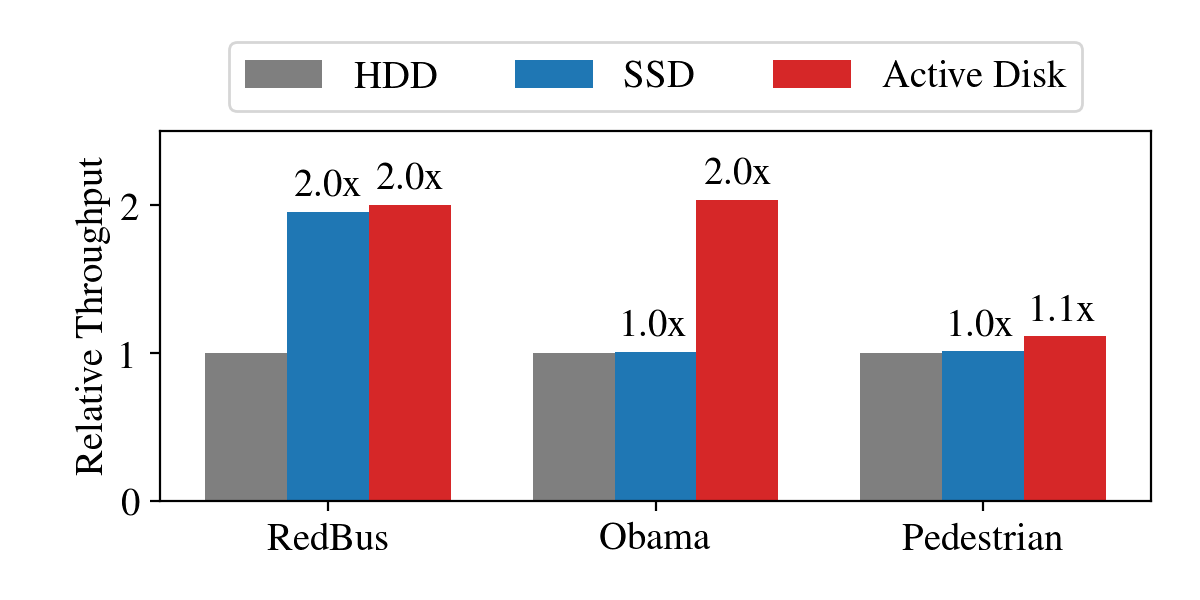

                expname                                            basedir  \
0      macro-redbus-hdd                     /mnt/hdd/fast20/jpeg/flickr50k   
1       macro-obama-hdd                     /mnt/hdd/fast20/jpeg/flickr50k   
2  macro-pedestrian-hdd  /mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...   

   avg_wall_ms  throughput  num_workers  bandwidth  avg_cpu_ms  
0     4.008679  249.458734            8  18.790009    6.535407  
1    68.350879   14.630390            8   1.102007  542.236143  
2     3.218230  310.729780            8  10.780236    8.430496  
x= [0. 1. 2.] y= [1. 1. 1.]
x= [0.25 1.25 2.25] y= [1.95001626 1.00461802 1.00752026]
x= [0.5 1.5 2.5] y= [1.99686674 2.03337838 1.11168066]


<IPython.core.display.Javascript object>


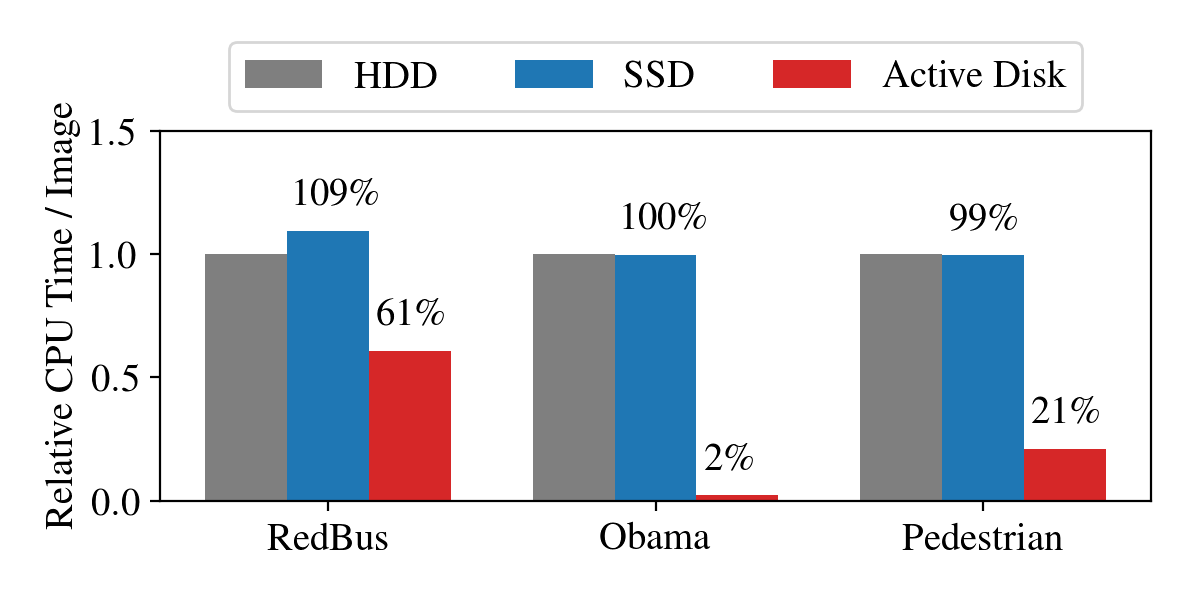

                expname                                            basedir  \
0      macro-redbus-hdd                     /mnt/hdd/fast20/jpeg/flickr50k   
1       macro-obama-hdd                     /mnt/hdd/fast20/jpeg/flickr50k   
2  macro-pedestrian-hdd  /mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...   

   avg_wall_ms  throughput  num_workers  bandwidth  avg_cpu_ms  
0     4.008679  249.458734            8  18.790009    6.535407  
1    68.350879   14.630390            8   1.102007  542.236143  
2     3.218230  310.729780            8  10.780236    8.430496  
x= [0. 1. 2.] y= [1. 1. 1.]
x= [0.25 1.25 2.25] y= [1.09423326 0.99750714 0.99414584]
annotating CPU time saving
0.25 1.0942332648341135 1.0942332648341135
1.25 0.9975071424636592 0.9975071424636592
2.25 0.9941458353483676 0.9941458353483676
x= [0.5 1.5 2.5] y= [0.60800195 0.02063395 0.21100086]
annotating CPU time saving
0.5 0.6080019538375688 0.6080019538375688
1.5 0.020633949254089266 0.020633949254089266
2.5 0.211000858

In [217]:
plot_macro_relative('throughput', 'Relative Throughput', savefig_path='macro-throughput-relative.pdf', ymax=2.5)
plot_macro_relative('avg_cpu_ms', 'Relative CPU Time / Image', savefig_path='macro-cputime-relative.pdf', ymax=1.5, fn=lambda y0,y: y/y0)


## Broken-Y Plot for Obama CPU Time

<IPython.core.display.Javascript object>


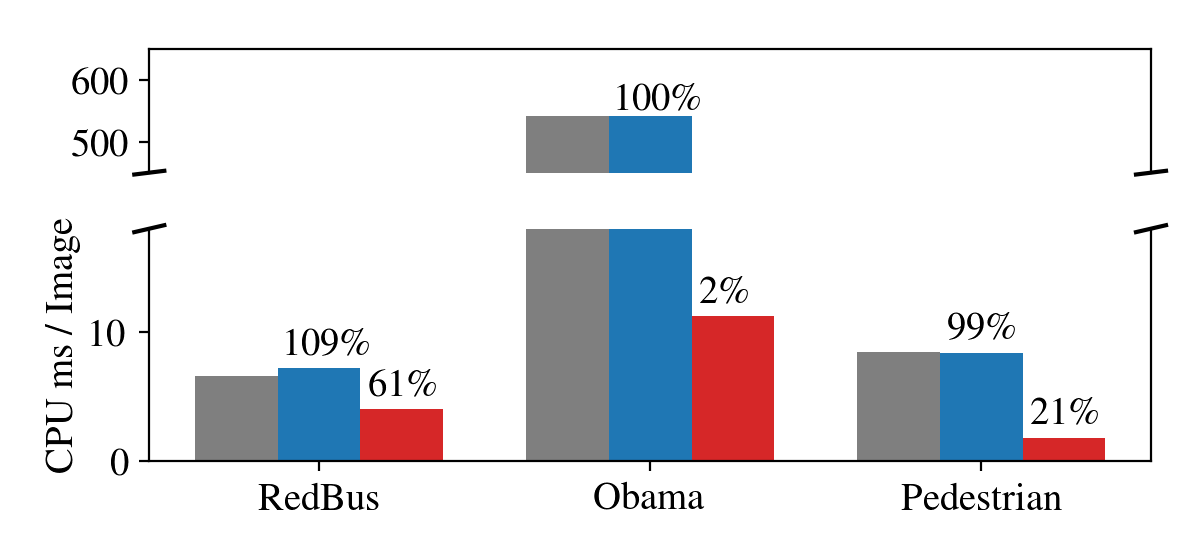

annotating CPU time saving
0.25 7.15126012759 1.09423326483
1.25 540.884425092 0.997507142464
2.25 8.38114209058 0.994145835348
annotating CPU time saving
0.5 3.97354044125 0.608001953838
1.5 11.188473049 0.0206339492541
2.5 1.77884181155 0.211000858783
annotating CPU time saving
0.25 7.15126012759 1.09423326483
1.25 18.0 0.0331958690829
2.25 8.38114209058 0.994145835348
annotating CPU time saving
0.5 3.97354044125 0.608001953838
1.5 11.188473049 0.0206339492541
2.5 1.77884181155 0.211000858783


In [233]:
%matplotlib notebook

col = 'avg_cpu_ms'
ylabel = 'CPU ms / Image'

UPPER_YMAX = 650
LOWER_YMAX = 18

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,2.8), gridspec_kw={'height_ratios': [1.6, 3]})

for ax in (ax1, ax2):
    ind = np.arange(len(workloads))
    width = 0.25       

    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])

        x, y = ind + i*width, df[col]
        
        # clip lower plot's y
        if ax is ax2:
            y = np.minimum(LOWER_YMAX, y)
        
        ax.bar(x, y, width, label=dev_name, color=c)
        
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['avg_cpu_ms']):
                print x1, y1, s1
                ax.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + (10 if ax is ax1 else 1)))

# upper subplot
ax1.set_ylim(450, UPPER_YMAX)
ax1.spines['bottom'].set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off', top=False, bottom=False)

# lower subplot
ax2.set_ylim(None, LOWER_YMAX)
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
plt.ylabel(ylabel)
# ax2.yaxis.set_label_coords(-.05,1)

plt.xticks(ind + width, map(pretty, workloads))
# plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
# plt.legend(loc='best')

plt.tight_layout()
plt.savefig('macro-cputime-brokeny.pdf', bbox_inches ='tight')

plt.show()